<a href="https://colab.research.google.com/github/IASG6/Machine-Learning/blob/main/Gato_vs_Cachorro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
import PIL

from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

In [ ]:
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


############################################################################################# 100.0%


In [ ]:
import os
import zipfile

local_zip = '/content/kagglecatsanddogs_5340.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# Cria listas para armazenar os caminhos de imagens e seus respectivos rótulos (0 para 'Cat' e 1 para 'Dog').
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Dog/4692.jpg 1


In [ ]:
# Cria um DataFrame com os caminhos das imagens e seus rótulos, embaralha as linhas e exibe as primeiras 5 entradas.
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

images  label
0   PetImages/Cat/2845.jpg      0
1   PetImages/Dog/4631.jpg      1
2  PetImages/Dog/10487.jpg      1
3   PetImages/Dog/5682.jpg      1
4   PetImages/Cat/4573.jpg      0

In [ ]:
# Verifica e imprime os caminhos de imagens que não possuem a extensão '.jpg'.
for i in df['images']:
    if '.jpg' not in i:
        print(i)

PetImages/Cat/Thumbs.db
PetImages/Dog/Thumbs.db


In [ ]:
# Tenta abrir cada imagem e adiciona ao lista 'l' os caminhos das imagens que não podem ser abertas.
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

['PetImages/Cat/Thumbs.db',
 'PetImages/Dog/11702.jpg',
 'PetImages/Cat/666.jpg',
 'PetImages/Dog/Thumbs.db']

In [ ]:
# deletar arquivos db
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

24998

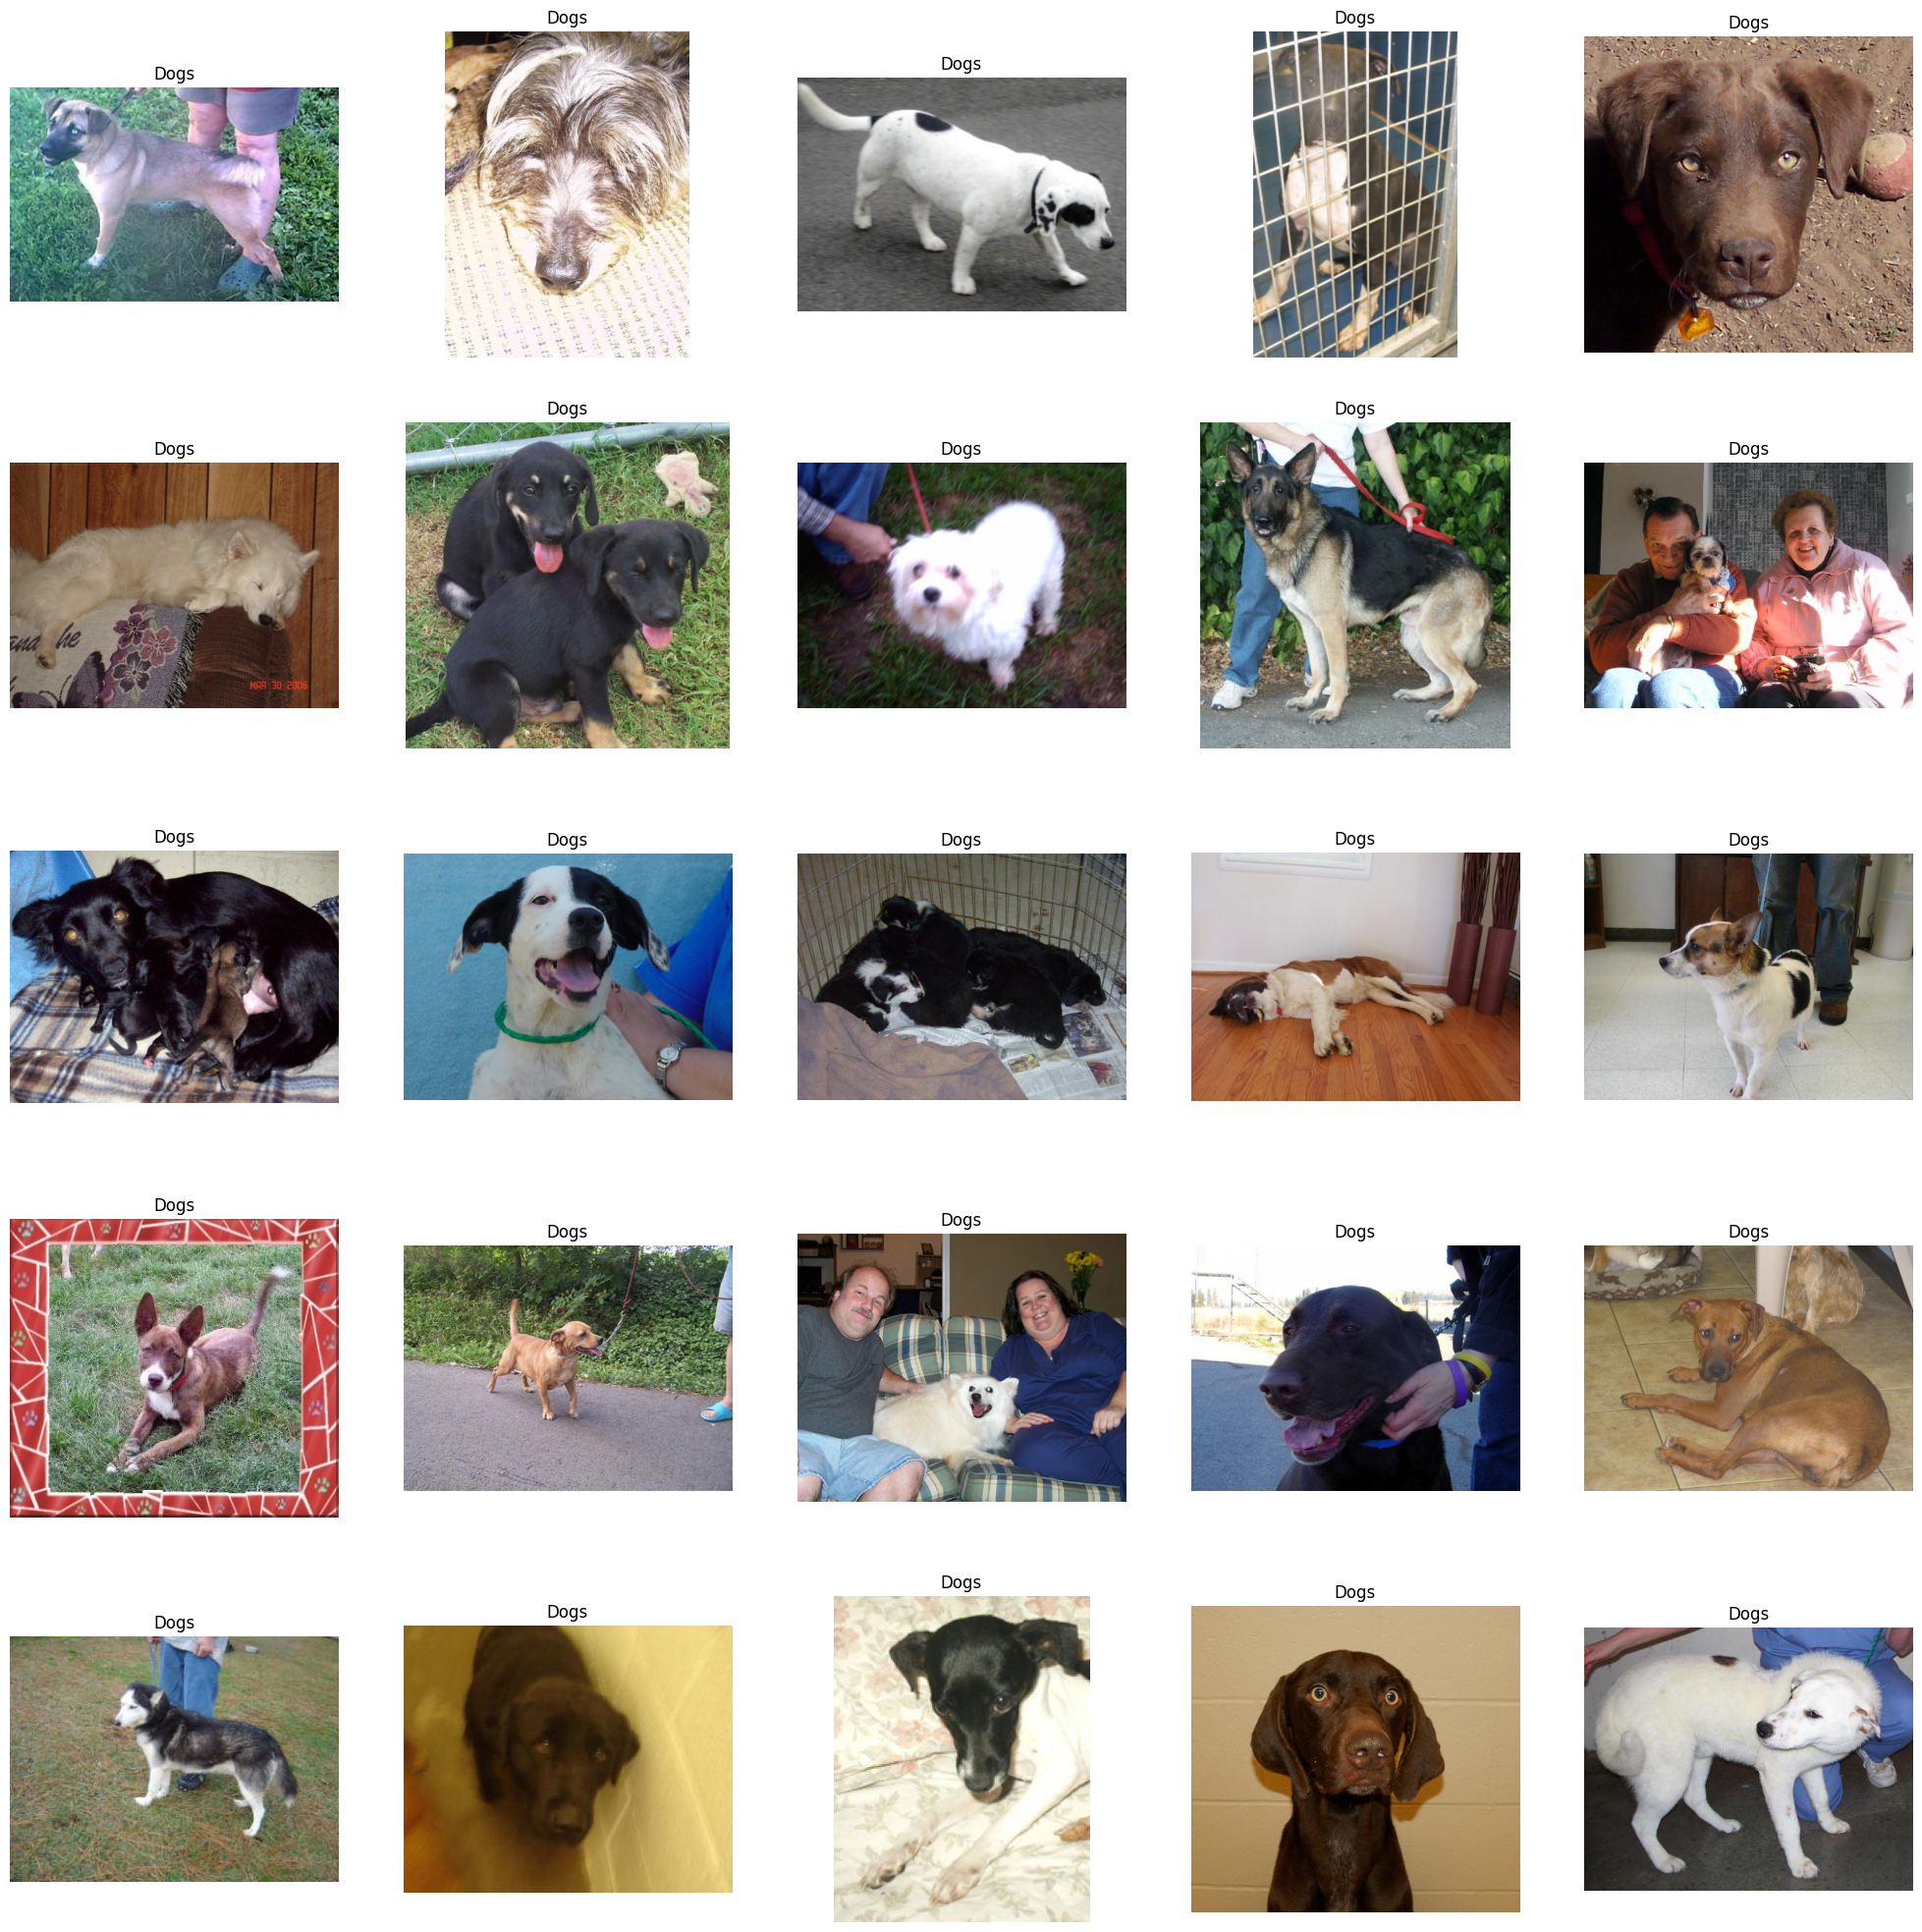

In [ ]:
# para exibir a grade de imagens
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

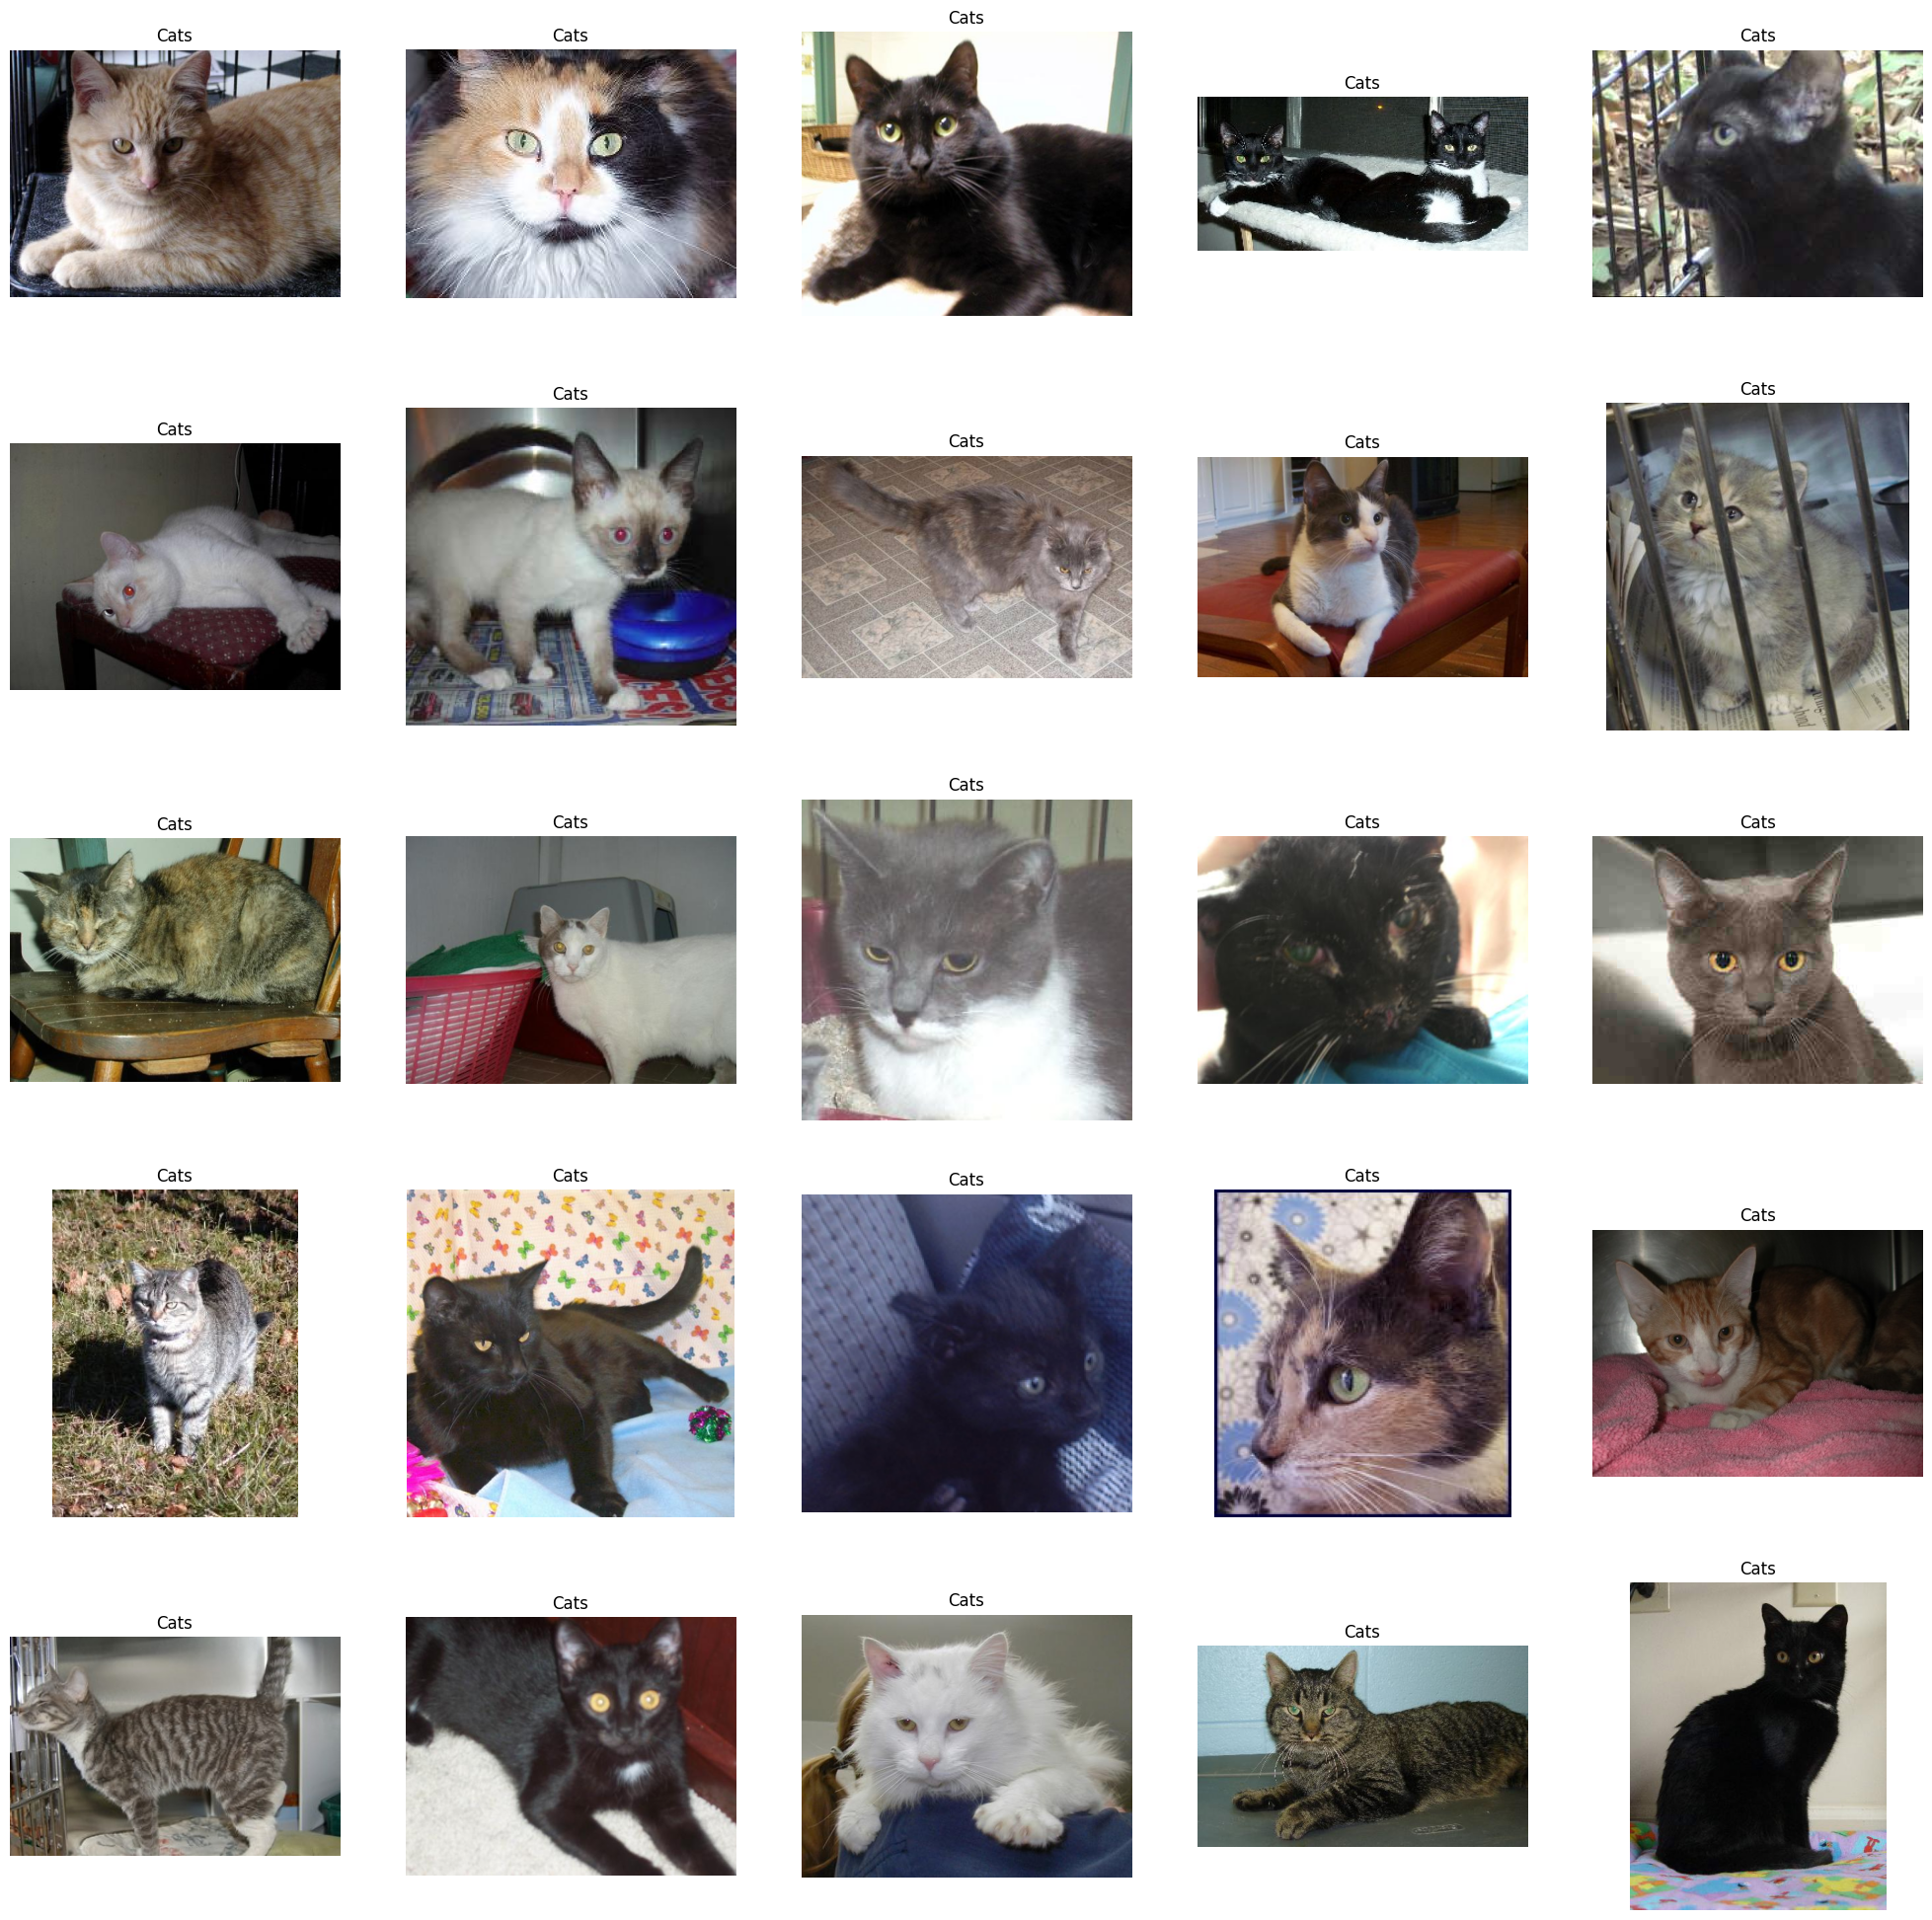

In [ ]:
# para exibir a grade de imagens
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

In [ ]:
# Converte os valores da coluna 'label' para o tipo de dado string.
df['label'] = df['label'].astype('str')

In [ ]:
# Exibe as primeiras 5 linhas do DataFrame para visualização dos dados.
df.head()

images label
0   PetImages/Cat/2845.jpg     0
1   PetImages/Dog/4631.jpg     1
2  PetImages/Dog/10487.jpg     1
3   PetImages/Dog/5682.jpg     1
4   PetImages/Cat/4573.jpg     0

In [ ]:
# Divide o DataFrame em conjuntos de treino (80%) e teste (20%) de forma aleatória.
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Cria um gerador de imagens para o conjunto de treino com aumento de dados (normalização, rotação, cisalhamento, zoom e flip horizontal)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# Cria um gerador de imagens para o conjunto de validação com apenas normalização
val_generator = ImageDataGenerator(rescale = 1./255)

# Cria o iterador de dados para o conjunto de treino a partir do DataFrame 'train'
train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

# Cria o iterador de dados para o conjunto de validação a partir do DataFrame 'test'
val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
# Cria um modelo sequencial com camadas convolucionais, pooling, flatten e camadas densas para classificação binária.
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [ ]:
# Compila o modelo com o otimizador Adam, função de perda de entropia cruzada binária e métrica de acurácia, e exibe um resumo da arquitetura do modelo.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Treina o modelo por 10 épocas utilizando o conjunto de treino e validação fornecidos pelos geradores de dados.
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 440s 10s/step - accuracy: 0.4956 - loss: 0.7925 - val_accuracy: 0.6028 - val_loss: 0.6681
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 433s 10s/step - accuracy: 0.6022 - loss: 0.6594 - val_accuracy: 0.6476 - val_loss: 0.6174
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 438s 10s/step - accuracy: 0.6597 - loss: 0.6166 - val_accuracy: 0.6844 - val_loss: 0.5899
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 445s 10s/step - accuracy: 0.7053 - loss: 0.5612 - val_accuracy: 0.7358 - val_loss: 0.5271
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 431s 10s/step - accuracy: 0.7394 - loss: 0.5241 - val_accuracy: 0.7346 - val_loss: 0.5246
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 433s 10s/step - accuracy: 0.7515 - loss: 0.5103 - val_accuracy: 0.7676 - val_loss: 0.4759
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 433s 10s/step - accuracy: 0.7645 - loss: 0.4849 - val_accuracy: 0.7778 - val_loss: 0.4631
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 430s 10s/step - accuracy: 0.7767 - loss: 0.4714 - val_accuracy: 0.

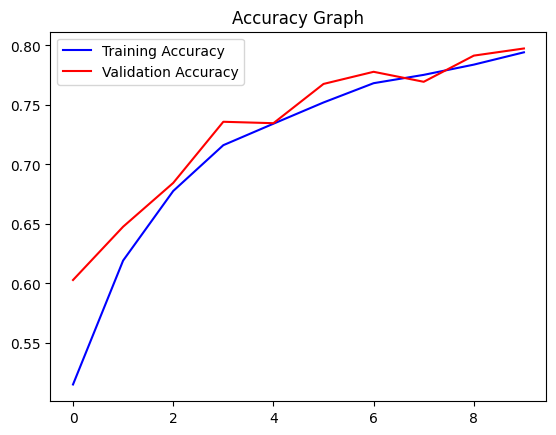

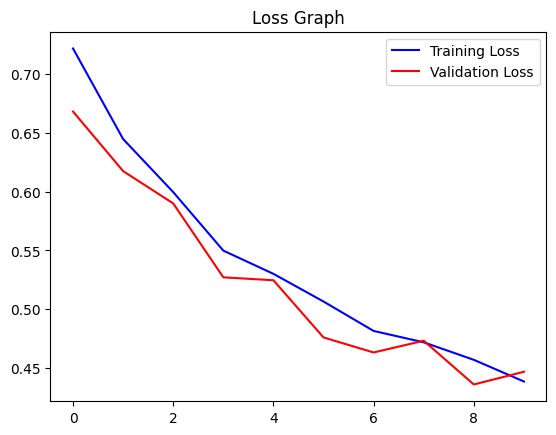

In [ ]:
# Plota os gráficos de acurácia e perda durante o treinamento e validação ao longo das épocas.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
# Carrega, normaliza e ajusta o formato de uma imagem para previsão, em seguida classifica como 'Cat' ou 'Dog' com base no modelo treinado.
image_path = "/content/Gato.jpg"
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0
img = img.reshape(1, 128, 128, 3)
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Cat
